In [1]:
from src.data import gedi_pipeline

import seaborn as sns
from fastai.tabular.all import save_pickle, load_pickle
import matplotlib.pyplot as plt

import ee
import geopandas as gpd
from src.data import gedi_pipeline
from src.data.ee import lcms_import
from src.processing.regen import regen_analysis
from src.data.ee import ee_utils
from src.data.fire_perimeters import FirePerimeters, FirePerimetersDB, Fire, match_gedi_to_raster, FireRastersDB
from src.data import fire_perimeters
from src.data import gedi_raster_matching
from src.data import raster
import rasterio as rio
from src.data import shape_processor
import matplotlib.pyplot as plt
from src.data import k_nn
import pandas as pd
import scipy as sp
import statsmodels.api as sm
from src.constants import DATA_PATH, USER_PATH
from fitter import Fitter, get_common_distributions, get_distributions
import seaborn as sns
from fastai.tabular.all import save_pickle
from scipy.stats import pearsonr
from src.visualization.dists import plot_pdf
from src.data import gedi_pipeline
import seaborn as sns
from fastai.tabular.all import load_pickle, save_pickle, patch
from src.constants import DATA_PATH
from src.data import gedi_raster_matching
from src.processing.rf import split_data
from fastai.tabular.all import *
from sklearn.metrics import *
from src.utils.logging_util import get_logger
from sklearn.ensemble import RandomForestRegressor
from src.processing.rf import train
from sklearn.inspection import PartialDependenceDisplay
from fastbook import *

palette = sns.color_palette("Set2")
sns.set_theme(style="white", palette="Set2")

import importlib
importlib.reload(regen_analysis)
importlib.reload(gedi_pipeline)
importlib.reload(ee_utils)
importlib.reload(gedi_raster_matching)
importlib.reload(raster)
importlib.reload(fire_perimeters)


2023-11-06 12:31:39,152 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_pipeline.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2023-11-06 12:31:39,154 DEBUG: Logger /home/jk871/fire-regen/src/data/ee/ee_utils.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2023-11-06 12:31:39,155 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_raster_matching.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2023-11-06 12:31:39,156 DEBUG: Logger /home/jk871/fire-regen/src/data/fire_perimeters.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


<module 'src.data.fire_perimeters' from '/home/jk871/fire-regen/src/data/fire_perimeters.py'>

In [2]:
gedi_burned, gedi_unburned = gedi_pipeline.load_stage_11()

AttributeError: module 'src.data.gedi_pipeline' has no attribute 'load_stage_11'

In [3]:
gedi_unburned = gedi_unburned[gedi_unburned.dw_land_cover_std == 0]
gedi_unburned = gedi_unburned[gedi_unburned.dw_land_cover_median.isin([1, 2, 5])]
gedi_burned = gedi_burned[gedi_burned.dw_land_cover_median.isin([1, 2, 5])]
gedi_burned = gedi_burned.dropna()
gedi_unburned = gedi_unburned.dropna()
gedi_burned = gedi_burned[gedi_burned.time_since_burn < 36]

In [4]:
sierra_conservancy = gpd.read_file(f"{USER_PATH}/data/shapefiles/sierras.shp")
gedi_unburned = gedi_unburned.sjoin(sierra_conservancy, how="inner", predicate="within")
gedi_burned = gedi_burned.sjoin(sierra_conservancy, how="inner", predicate="within")

In [ ]:
gedi_burned = gedi_burned[gedi_burned.burn_count == 1]

In [5]:
nn_indeces, nn_distances = k_nn.nearest_neighbors(gedi_burned, gedi_unburned, 200)

In [ ]:
gedi_burned['agbd_control'] = np.apply_along_axis(
        lambda x: gedi_unburned.iloc[x].agbd.mean(), 1, nn_indeces)

In [6]:
gedi_burned['rh_98_control'] = np.apply_along_axis(
        lambda x: gedi_unburned.iloc[x].rh_98.mean(), 1, nn_indeces)

In [14]:
gedi_burned['rh_98_control_median'] = np.apply_along_axis(
        lambda x: gedi_unburned.iloc[x].rh_98.median(), 1, nn_indeces)

In [ ]:
gedi_burned['pai_control'] = np.apply_along_axis(
        lambda x: gedi_unburned.iloc[x].pai.mean(), 1, nn_indeces)

In [7]:
gedi_burned['NDVI_control'] = np.apply_along_axis(
        lambda x: gedi_unburned.iloc[x].NDVI_mean.mean(), 1, nn_indeces)

In [15]:
gedi_burned['NDVI_control_median'] = np.apply_along_axis(
        lambda x: gedi_unburned.iloc[x].NDVI_mean.median(), 1, nn_indeces)

In [ ]:
gedi_burned['rh_70_control'] = np.apply_along_axis(
        lambda x: gedi_unburned.iloc[x].rh_70.mean(), 1, nn_indeces)

In [ ]:
gedi_burned['rh_25_control'] = np.apply_along_axis(
        lambda x: gedi_unburned.iloc[x].rh_25.mean(), 1, nn_indeces)

In [ ]:
gedi_burned['agbd_diff'] = gedi_burned.agbd_control - gedi_burned.agbd
gedi_burned['pai_diff'] = gedi_burned.pai_control - gedi_burned.pai
gedi_burned['NDVI_diff'] = gedi_burned.NDVI_control - gedi_burned.NDVI_mean
gedi_burned['rh_98_diff'] = gedi_burned.rh_98_control - gedi_burned.rh_98
gedi_burned['rh_70_diff'] = gedi_burned.rh_70_control - gedi_burned.rh_70
gedi_burned['rh_25_diff'] = gedi_burned.rh_25_control - gedi_burned.rh_25

In [8]:
#gedi_burned['agbd_rel'] = gedi_burned.agbd / gedi_burned.agbd_control
#gedi_burned['pai_rel'] = gedi_burned.pai / gedi_burned.pai_control
gedi_burned['NDVI_rel'] = gedi_burned.NDVI_mean / gedi_burned.NDVI_control
gedi_burned['rh_98_rel'] = gedi_burned.rh_98 / gedi_burned.rh_98_control
#gedi_burned['rh_70_rel'] = gedi_burned.rh_70 / gedi_burned.rh_70_control
#gedi_burned['rh_25_rel'] = gedi_burned.rh_25 / gedi_burned.rh_25_control

In [16]:
gedi_burned['NDVI_rel_median'] = gedi_burned.NDVI_mean / gedi_burned.NDVI_control_median
gedi_burned['rh_98_rel_median'] = gedi_burned.rh_98 / gedi_burned.rh_98_control_median

In [17]:
GEDI_PATH = f"{DATA_PATH}/gedi_intermediate"
save_pickle(
    f"{GEDI_PATH}/sierras_gedi_combined_stage_11_burned_with_controls_Oct29.pkl",
    gedi_burned)
save_pickle(
    f"{GEDI_PATH}/sierras_gedi_combined_stage_11_unburned_with_controls_Oct29.pkl",
    gedi_unburned)

In [2]:
GEDI_PATH = f"{DATA_PATH}/gedi_intermediate"
gedi_burned = load_pickle(f"{GEDI_PATH}/sierras_gedi_combined_stage_11_burned_with_controls_Oct29.pkl")
gedi_unburned = load_pickle(f"{GEDI_PATH}/sierras_gedi_combined_stage_11_unburned_with_controls_Oct29.pkl")

In [3]:
len(gedi_unburned)

4291380

## High Severuty RH98

In [14]:
high_severity = gedi_burned[(gedi_burned.severity == 4)]
low_severity = gedi_burned[(gedi_burned.severity == 2)]

<AxesSubplot: xlabel='time_since_burn', ylabel='NDVI_mean'>

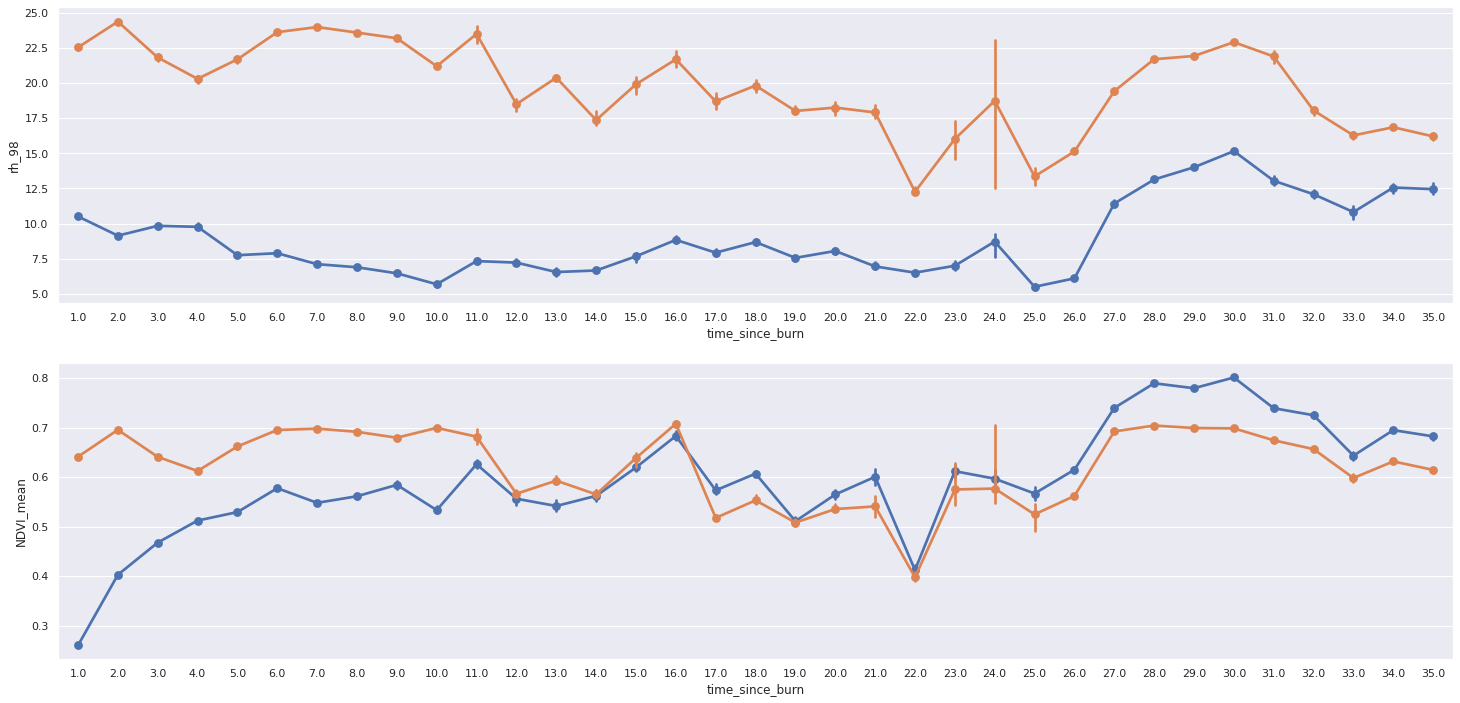

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(25, 12))
df = high_severity
sns.pointplot(df, x="time_since_burn", y="rh_98",  ax=ax[0], estimator="median")
sns.pointplot(df, x="time_since_burn", y="rh_98_control",  ax=ax[0], estimator="median")
sns.pointplot(df, x="time_since_burn", y="NDVI_mean",  ax=ax[1], estimator="median")
sns.pointplot(df, x="time_since_burn", y="NDVI_control",  ax=ax[1], estimator="median")

In [30]:
df = high_severity
high_rh_98_rel_medians = df.groupby("time_since_burn").rh_98_rel.median()
high_NDVI_rel_medians = df.groupby("time_since_burn").NDVI_rel.median()
high_slope_medians = df.groupby("time_since_burn").slope_median.median()
high_elevation_medians = df.groupby("time_since_burn").elevation_median.median()
high_elevation_difference_tdx_medians = df.groupby("time_since_burn").elevation_difference_tdx.median()

In [31]:
df = low_severity
low_rh_98_rel_medians = df.groupby("time_since_burn").rh_98_rel.median()
low_NDVI_rel_medians = df.groupby("time_since_burn").NDVI_rel.median()
low_slope_medians = df.groupby("time_since_burn").slope_median.median()
low_elevation_medians = df.groupby("time_since_burn").elevation_median.median()
low_elevation_difference_tdx_medians = df.groupby("time_since_burn").elevation_difference_tdx.median()

In [9]:
print(pearsonr(high_severity.rh_98_rel, high_severity.time_since_burn))

PearsonRResult(statistic=0.0658571646193343, pvalue=8.630522495461769e-172)


In [16]:
x = np.array(range(1, 36))
y = high_rh_98_rel_medians.to_numpy()
X = sm.add_constant(np.stack([x, x**2]).T)
model = sm.OLS(y, X)
fitted_model = model.fit()
print(fitted_model.summary(xname=['const', 'x1', 'x2']))  

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     72.19
Date:                Sun, 05 Nov 2023   Prob (F-statistic):           1.38e-12
Time:                        14:38:11   Log-Likelihood:                 56.059
No. Observations:                  35   AIC:                            -106.1
Df Residuals:                      32   BIC:                            -101.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4814      0.027     17.561      0.0

In [17]:
x = np.array(range(1, 36))
y = low_rh_98_rel_medians.to_numpy()
X = sm.add_constant(np.stack([x, x**2]).T)
model = sm.OLS(y, X)
fitted_model = model.fit()
print(fitted_model.summary(xname=['const', 'x1', 'x2']))  

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     23.23
Date:                Sun, 05 Nov 2023   Prob (F-statistic):           5.87e-07
Time:                        14:38:22   Log-Likelihood:                 43.052
No. Observations:                  35   AIC:                            -80.10
Df Residuals:                      32   BIC:                            -75.44
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1205      0.040     28.185      0.0

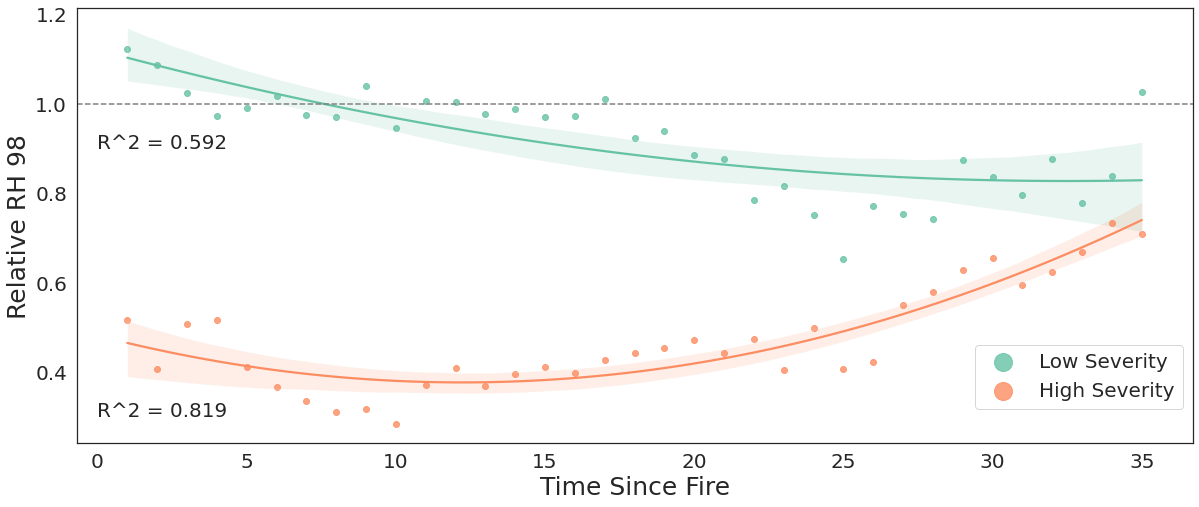

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
sns.regplot(x=pd.Series(range(1, 36)), y=low_rh_98_rel_medians, ax=ax, order=2, color=palette[0], label="Low Severity")
sns.regplot(x=pd.Series(range(1, 36)), y=high_rh_98_rel_medians, ax=ax, order=2, color=palette[1], label="High Severity")
#ax.set_title("Canopy Height Recovery", fontsize=20)
#ax.set_ylim((0, 1.1))
ax.axhline(1.0, linestyle="--", color="gray")
ax.text(0, 0.9, "R^2 = 0.592", fontsize=20)
ax.text(0, 0.3, "R^2 = 0.819", fontsize=20)
ax.set_xlabel("Time Since Fire", fontsize=25)
ax.set_ylabel("Relative RH 98", fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(fontsize=20, loc='best', bbox_to_anchor=(0.5, 0., 0.5, 0.25), markerscale=3)


Text(0, 0.9, 'R^2 = 0.819')

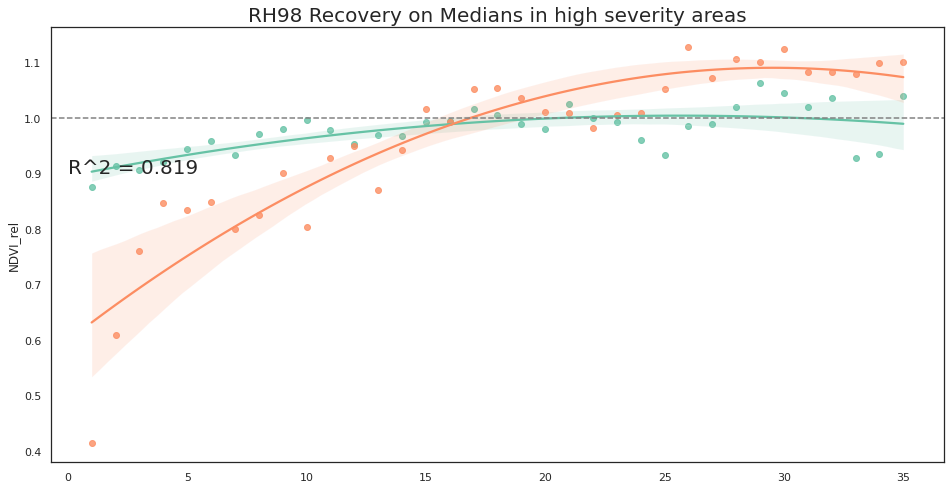

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.regplot(x=pd.Series(range(1, 36)), y=low_NDVI_rel_medians, ax=ax, order=2, color=palette[0])
sns.regplot(x=pd.Series(range(1, 36)), y=high_NDVI_rel_medians, ax=ax, order=2, color=palette[1])
ax.set_title("RH98 Recovery on Medians in high severity areas", fontsize=20)
#ax.set_ylim((0, 1.1))
ax.axhline(1.0, linestyle="--", color="gray")
ax.text(0, 0.9, "R^2 = 0.819", fontsize=20)

<AxesSubplot: xlabel='time_since_burn', ylabel='NDVI_mean'>

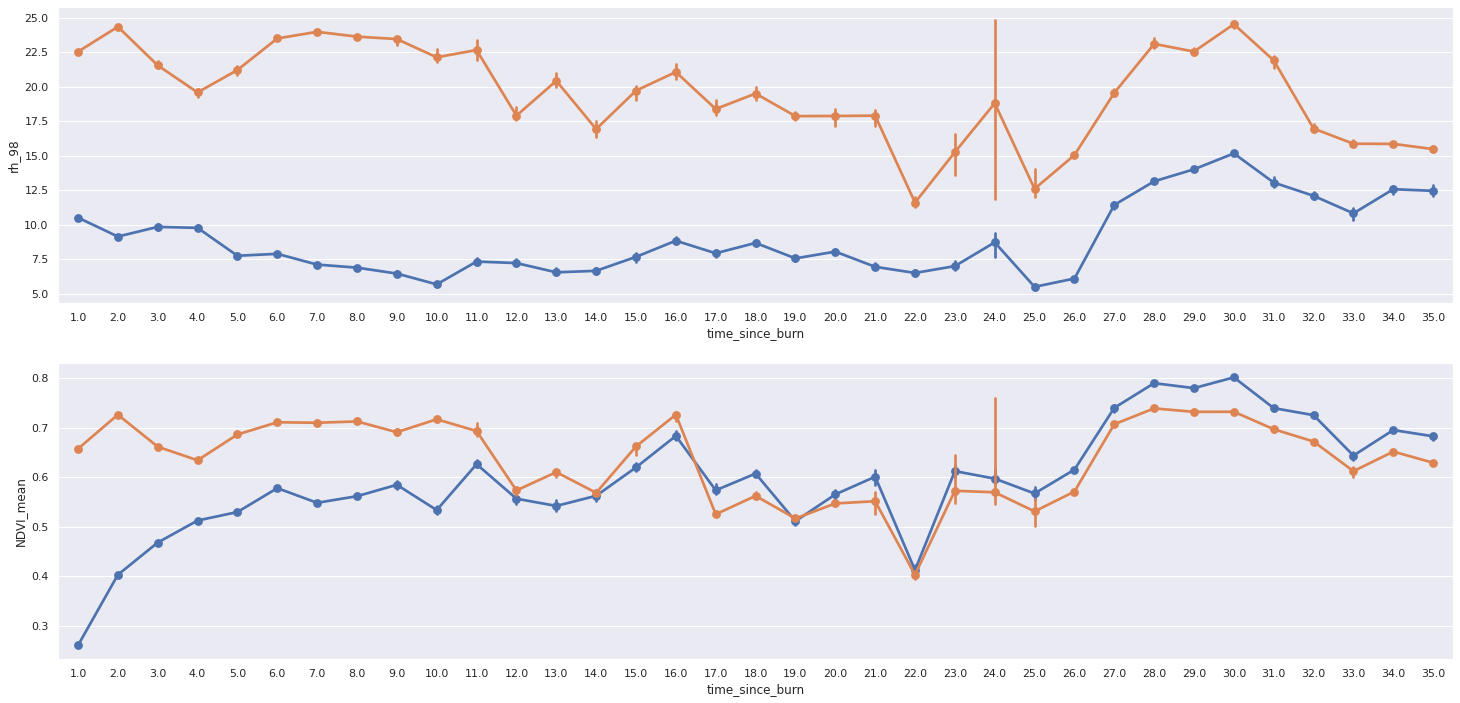

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(25, 12))
df = high_severity
sns.pointplot(df, x="time_since_burn", y="rh_98",  ax=ax[0], estimator="median")
sns.pointplot(df, x="time_since_burn", y="rh_98_control_median",  ax=ax[0], estimator="median")
sns.pointplot(df, x="time_since_burn", y="NDVI_mean",  ax=ax[1], estimator="median")
sns.pointplot(df, x="time_since_burn", y="NDVI_control_median",  ax=ax[1], estimator="median")

In [20]:
low_severity = gedi_burned[(gedi_burned.severity == 2)]

<AxesSubplot: xlabel='time_since_burn', ylabel='NDVI_mean'>

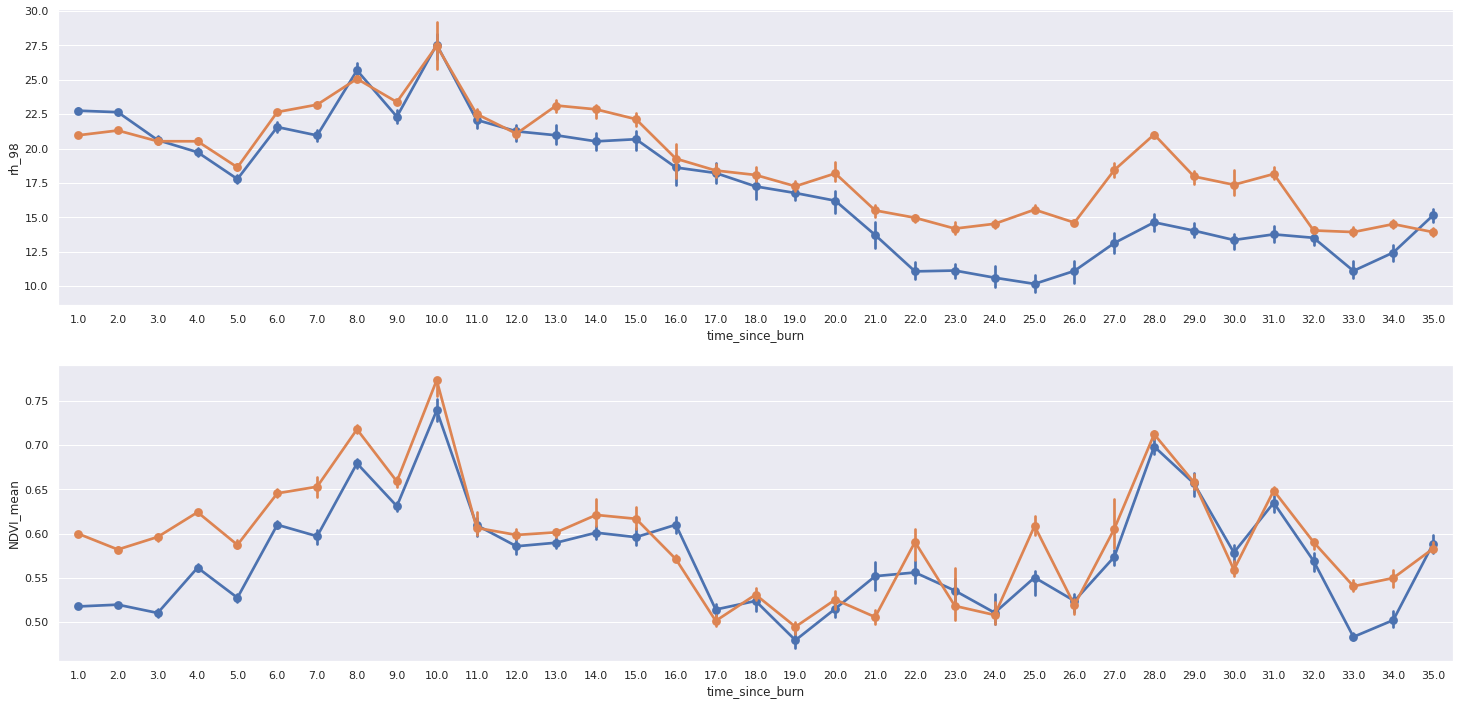

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(25, 12))
df = low_severity
sns.pointplot(df, x="time_since_burn", y="rh_98",  ax=ax[0], estimator="median")
sns.pointplot(df, x="time_since_burn", y="rh_98_control",  ax=ax[0], estimator="median")
sns.pointplot(df, x="time_since_burn", y="NDVI_mean",  ax=ax[1], estimator="median")
sns.pointplot(df, x="time_since_burn", y="NDVI_control",  ax=ax[1], estimator="median")

<AxesSubplot: xlabel='time_since_burn', ylabel='NDVI_mean'>

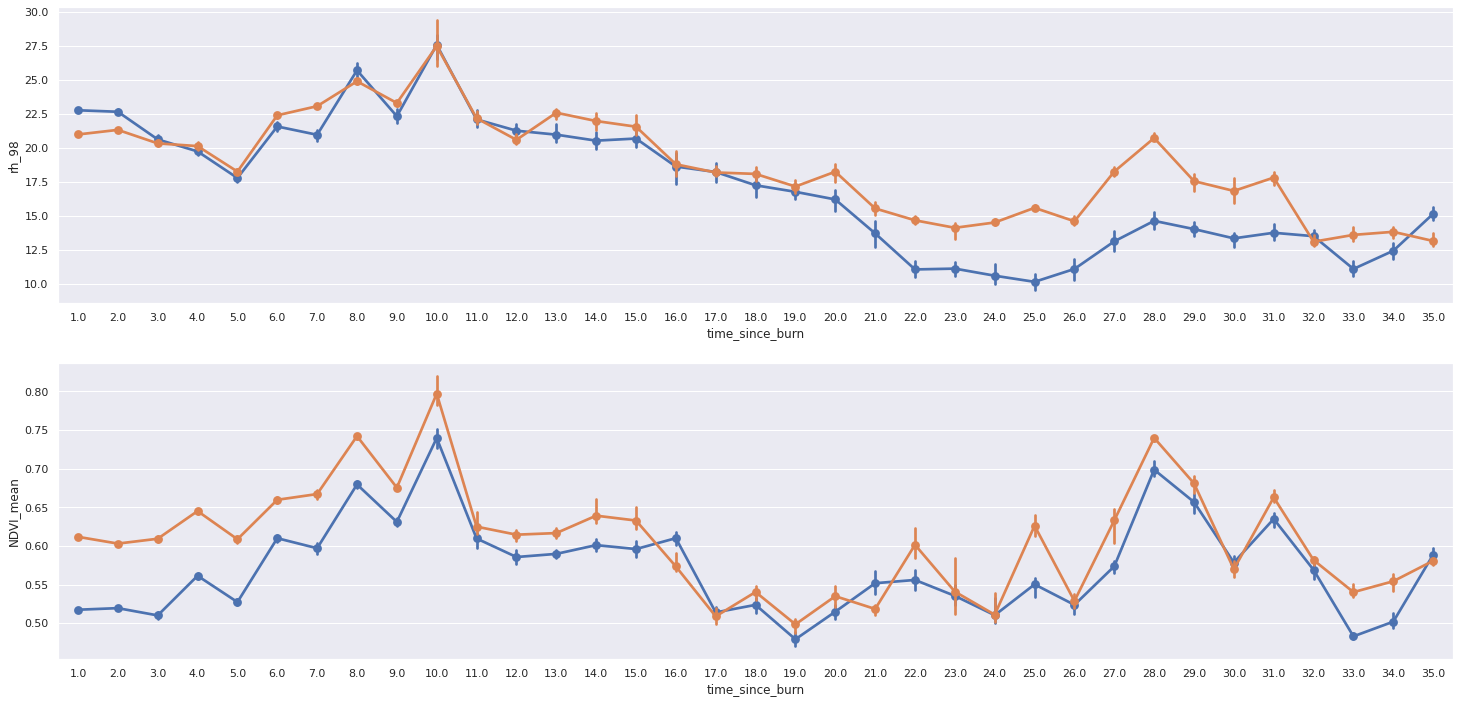

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(25, 12))
df = low_severity
sns.pointplot(df, x="time_since_burn", y="rh_98",  ax=ax[0], estimator="median")
sns.pointplot(df, x="time_since_burn", y="rh_98_control_median",  ax=ax[0], estimator="median")
sns.pointplot(df, x="time_since_burn", y="NDVI_mean",  ax=ax[1], estimator="median")
sns.pointplot(df, x="time_since_burn", y="NDVI_control_median",  ax=ax[1], estimator="median")

### Land Cover

<AxesSubplot: title={'center': 'DW Land Cover for Burned Regions vs. Time Since Burn'}, xlabel='time_since_burn', ylabel='Count'>

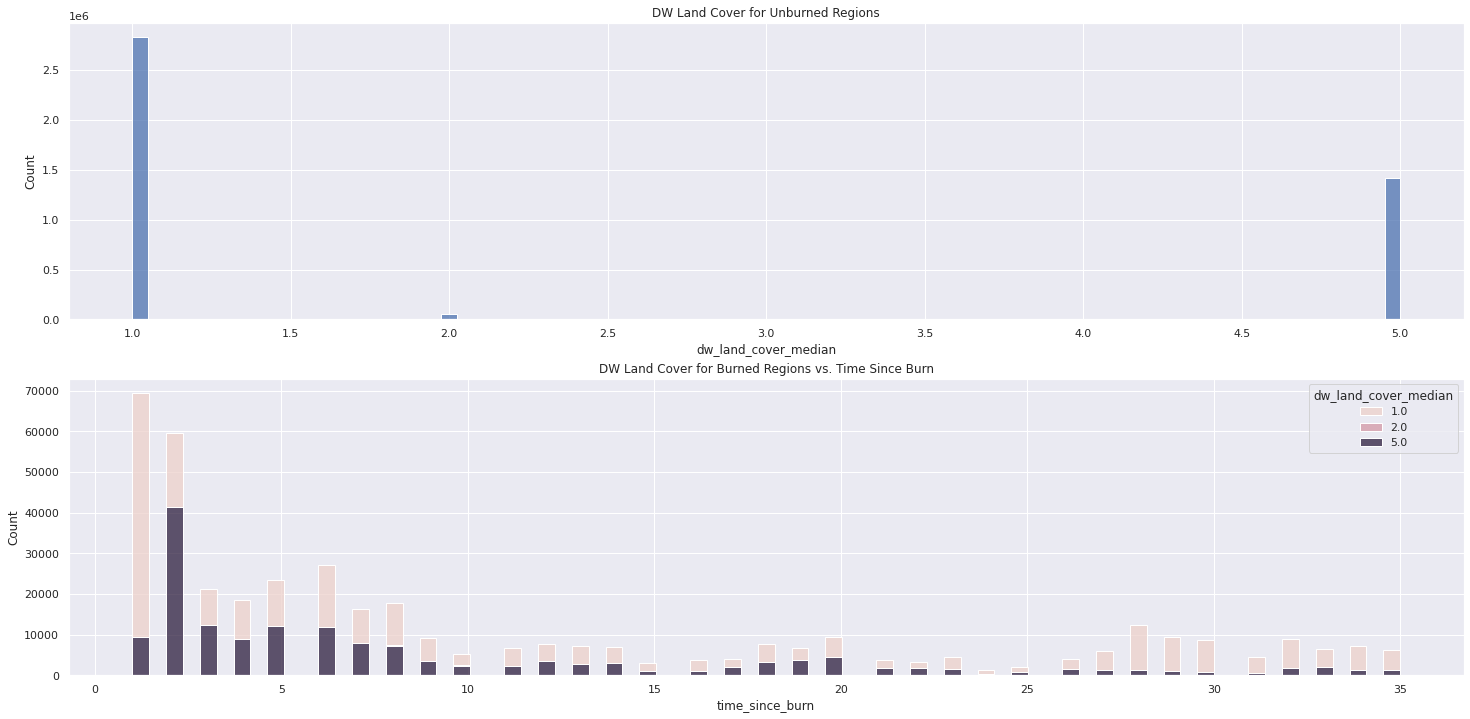

In [28]:
fig, ax = plt.subplots(2, 1, figsize=(25, 12))
ax[0].set_title("DW Land Cover for Unburned Regions")
sns.histplot(gedi_unburned, x="dw_land_cover_median", ax=ax[0])
ax[1].set_title("DW Land Cover for Burned Regions vs. Time Since Burn")
sns.histplot(gedi_burned, x="time_since_burn", hue="dw_land_cover_median", ax=ax[1], multiple="stack")

<AxesSubplot: title={'center': 'DW Land Cover for Burned Regions vs. Time Since Burn'}, xlabel='time_since_burn', ylabel='Count'>

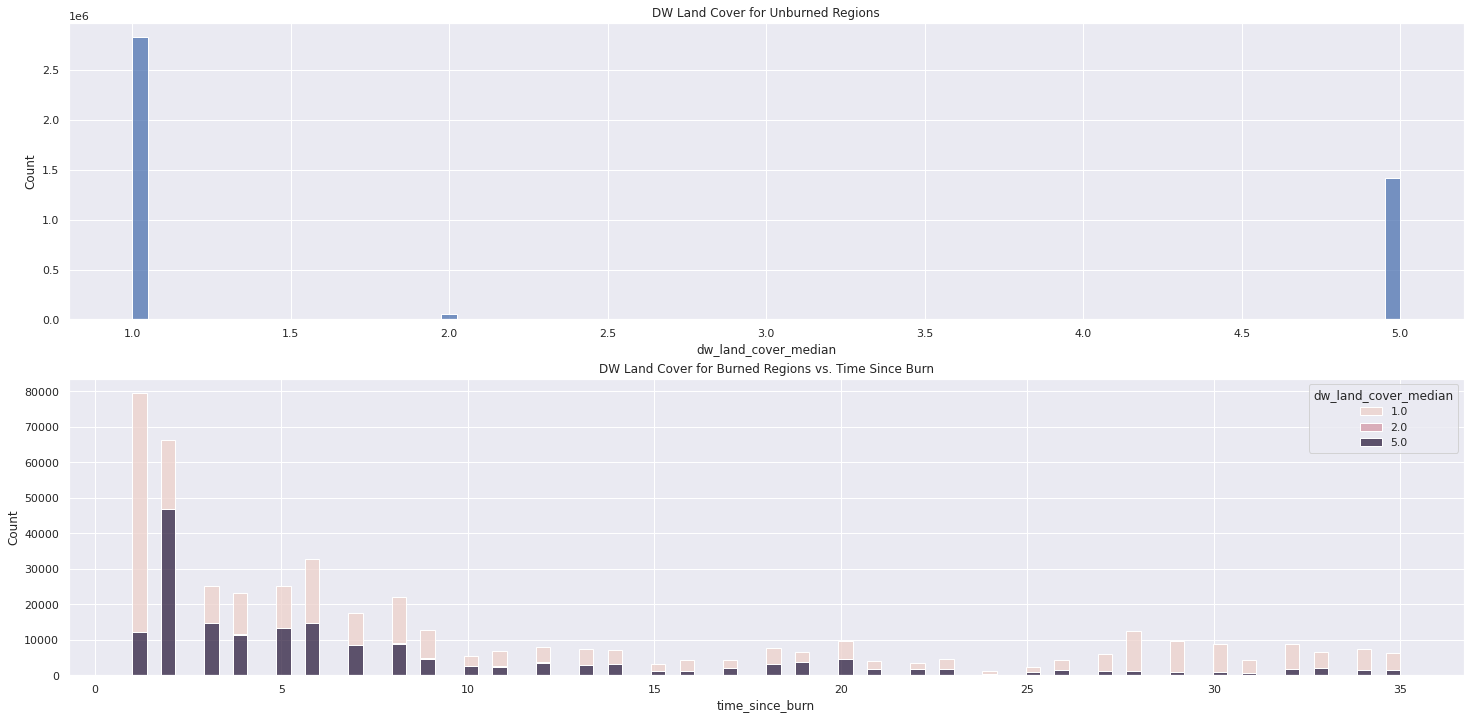

In [26]:
fig, ax = plt.subplots(2, 1, figsize=(25, 12))
ax[0].set_title("DW Land Cover for Unburned Regions")
sns.histplot(gedi_unburned, x="dw_land_cover_median", ax=ax[0])
ax[1].set_title("DW Land Cover for Burned Regions vs. Time Since Burn")
sns.histplot(gedi_burned, x="time_since_burn", hue="dw_land_cover_median", ax=ax[1], multiple="stack")

Text(0.5, 1.0, 'Distribution of slope in Unburned Regions')

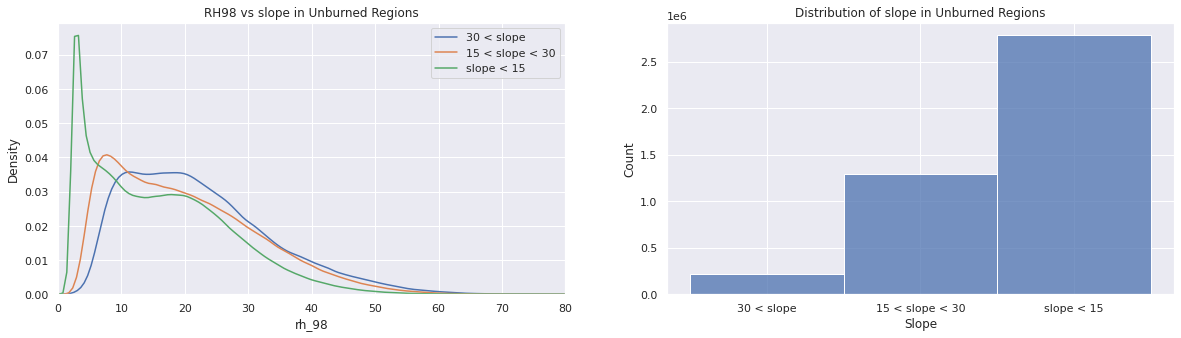

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
df = gedi_unburned
df1 = df[df.slope_median > 30]
df2 = df[(df.slope_median > 15) & (df.slope_median < 30)]
df3 = df[df.slope_median < 15]
df1["Slope"] = "30 < slope"
df2["Slope"] = "15 < slope < 30"
df3["Slope"] = "slope < 15"
df = pd.concat([df1, df2, df3])
sns.kdeplot(df[df.slope_median > 30], x="rh_98", ax=ax[0], label="30 < slope")
sns.kdeplot(df[(df.slope_median > 15) & (df.slope_median < 30)], x="rh_98", ax=ax[0], label="15 < slope < 30")
sns.kdeplot(df[df.slope_median < 15], x="rh_98", ax=ax[0], label="slope < 15")
ax[0].legend()
ax[0].set_xlim((0, 80))
sns.histplot(df, x="Slope", ax=ax[1])
ax[0].set_title("RH98 vs slope in Unburned Regions")
ax[1].set_title("Distribution of slope in Unburned Regions")

Text(0.5, 1.0, 'RH98 vs slope in Unburned Regions - with Land Cover classified as Trees')

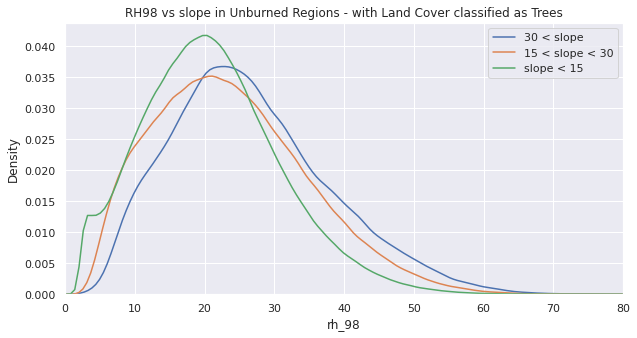

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
df = gedi_unburned[gedi_unburned.dw_land_cover_median == 1]
df1 = df[df.slope_median > 30]
df2 = df[(df.slope_median > 15) & (df.slope_median < 30)]
df3 = df[df.slope_median < 15]
df1["Slope"] = "30 < slope"
df2["Slope"] = "15 < slope < 30"
df3["Slope"] = "slope < 15"
df = pd.concat([df1, df2, df3])
sns.kdeplot(df[df.slope_median > 30], x="rh_98", ax=ax, label="30 < slope")
sns.kdeplot(df[(df.slope_median > 15) & (df.slope_median < 30)], x="rh_98", ax=ax, label="15 < slope < 30")
sns.kdeplot(df[df.slope_median < 15], x="rh_98", ax=ax, label="slope < 15")
ax.legend()
ax.set_xlim((0, 80))
ax.set_title("RH98 vs slope in Unburned Regions - with Land Cover classified as Trees")

Text(0.5, 1.0, 'RH98 vs slope in Unburned Regions - with Land Cover classified as Trees')

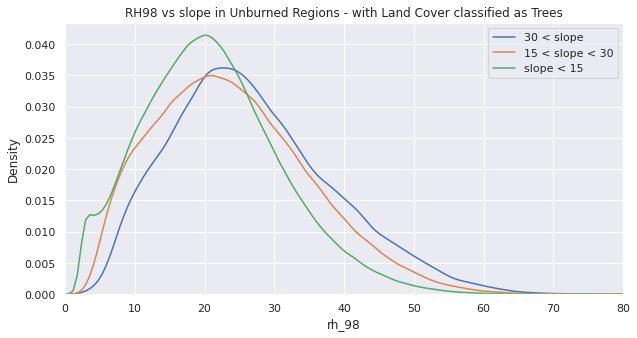

In [60]:
# TEST FOR NIGHT SHOTS
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
df = gedi_unburned[gedi_unburned.dw_land_cover_median == 1]
df = df[df.solar_elevation < 0]
df1 = df[df.slope_median > 30]
df2 = df[(df.slope_median > 15) & (df.slope_median < 30)]
df3 = df[df.slope_median < 15]
df1["Slope"] = "30 < slope"
df2["Slope"] = "15 < slope < 30"
df3["Slope"] = "slope < 15"
df = pd.concat([df1, df2, df3])
sns.kdeplot(df[df.slope_median > 30], x="rh_98", ax=ax, label="30 < slope")
sns.kdeplot(df[(df.slope_median > 15) & (df.slope_median < 30)], x="rh_98", ax=ax, label="15 < slope < 30")
sns.kdeplot(df[df.slope_median < 15], x="rh_98", ax=ax, label="slope < 15")
ax.legend()
ax.set_xlim((0, 80))
ax.set_title("RH98 vs slope in Unburned Regions - with Land Cover classified as Trees")

Text(0.5, 1.0, 'RH98 vs slope in Unburned Regions - with Land Cover classified as Trees')

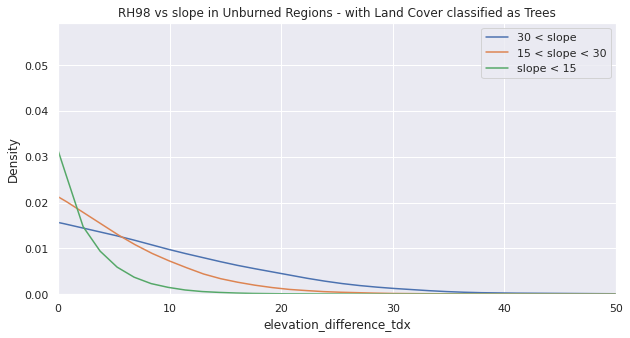

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
df = gedi_unburned[gedi_unburned.dw_land_cover_median == 1]
df1 = df[df.slope_median > 30]
df2 = df[(df.slope_median > 15) & (df.slope_median < 30)]
df3 = df[df.slope_median < 15]
df1["Slope"] = "30 < slope"
df2["Slope"] = "15 < slope < 30"
df3["Slope"] = "slope < 15"
df = pd.concat([df1, df2, df3])
sns.kdeplot(df[df.slope_median > 30], x="elevation_difference_tdx", ax=ax, label="30 < slope")
sns.kdeplot(df[(df.slope_median > 15) & (df.slope_median < 30)], x="elevation_difference_tdx", ax=ax, label="15 < slope < 30")
sns.kdeplot(df[df.slope_median < 15], x="elevation_difference_tdx", ax=ax, label="slope < 15")
ax.legend()
ax.set_xlim((0, 50))
ax.set_title("RH98 vs slope in Unburned Regions - with Land Cover classified as Trees")

Text(0.5, 1.0, 'RH98 vs slope in Unburned Regions - with Land Cover classified as Trees')

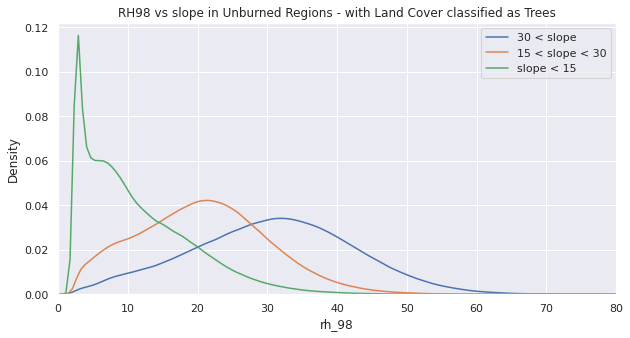

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
df = gedi_unburned
sns.kdeplot(df[df.elevation_difference_tdx < -20], x="rh_98", ax=ax, label="30 < slope")
sns.kdeplot(df[(df.elevation_difference_tdx > -20) & (df.elevation_difference_tdx < -5) ], x="rh_98", ax=ax, label="15 < slope < 30")
sns.kdeplot(df[df.elevation_difference_tdx > -5], x="rh_98", ax=ax, label="slope < 15")
ax.legend()
ax.set_xlim((0, 80))
ax.set_title("RH98 vs Elevation_Diff_TDX in Unburned Regions - with Land Cover classified as Trees")

Text(0.5, 1.0, 'RH98 vs Elevation_Diff_TDX in Unburned Regions \n (Land Cover classified as Trees)')

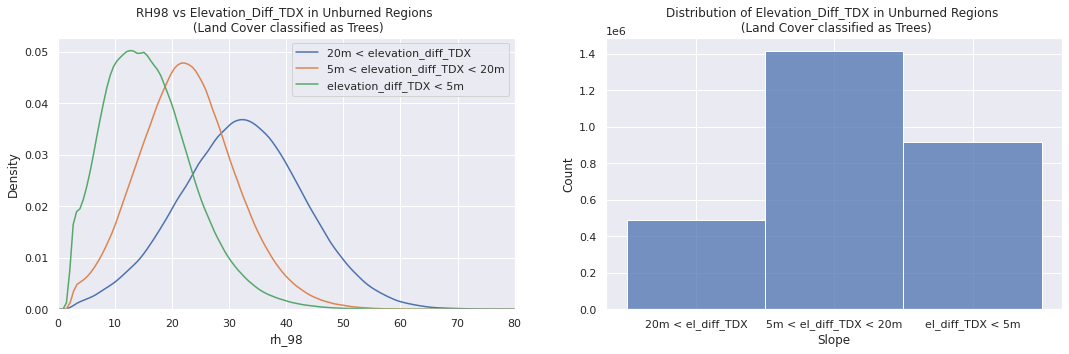

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))
df = gedi_unburned[gedi_unburned.dw_land_cover_median == 1]
df1 = df[df.elevation_difference_tdx < -20]
df2 = df[(df.elevation_difference_tdx > -20) & (df.elevation_difference_tdx < -5)]
df3 = df[df.elevation_difference_tdx > -5]
df1["Slope"] = "20m < el_diff_TDX"
df2["Slope"] = "5m < el_diff_TDX < 20m"
df3["Slope"] = "el_diff_TDX < 5m"
df = pd.concat([df1, df2, df3])
sns.kdeplot(df[df.elevation_difference_tdx < -20], x="rh_98", ax=ax[0], label="20m < elevation_diff_TDX")
sns.kdeplot(df[(df.elevation_difference_tdx > -20) & (df.elevation_difference_tdx < -5)], x="rh_98", ax=ax[0], label="5m < elevation_diff_TDX < 20m")
sns.kdeplot(df[df.elevation_difference_tdx > -5], x="rh_98", ax=ax[0], label="elevation_diff_TDX < 5m")
ax[0].legend()
ax[0].set_xlim((0, 80))
sns.histplot(df, x="Slope", ax=ax[1])
ax[1].set_title("Distribution of Elevation_Diff_TDX in Unburned Regions \n (Land Cover classified as Trees)")
ax[0].set_title("RH98 vs Elevation_Diff_TDX in Unburned Regions \n (Land Cover classified as Trees)")

In [47]:
df = gedi_unburned

from scipy.stats import pearsonr
print(pearsonr(df.rh_98, df.slope_median))
print(pearsonr(df.rh_98, df.elevation_median))
print(pearsonr(df.rh_98, df.elevation_difference_tdx))

PearsonRResult(statistic=0.24753324597349272, pvalue=0.0)
PearsonRResult(statistic=0.036840806540255816, pvalue=0.0)
PearsonRResult(statistic=-0.5353202850928204, pvalue=0.0)


In [88]:
df = gedi_burned

from scipy.stats import pearsonr
print(pearsonr(df.rh_98, df.slope_median))
print(pearsonr(df.rh_98, df.elevation_median))
print(pearsonr(df.rh_98, df.elevation_difference_tdx))

print(pearsonr(df.rh_98_rel, df.slope_median))
print(pearsonr(df.rh_98_rel, df.elevation_median))
print(pearsonr(df.rh_98_rel, df.elevation_difference_tdx))

PearsonRResult(statistic=0.23802874602443938, pvalue=0.0)
PearsonRResult(statistic=0.017453279669075023, pvalue=1.181356159873336e-29)
PearsonRResult(statistic=-0.37267228044466577, pvalue=0.0)
PearsonRResult(statistic=0.1709850323760272, pvalue=0.0)
PearsonRResult(statistic=0.024561426570387995, pvalue=4.8856282504186296e-57)
PearsonRResult(statistic=-0.22061940101556846, pvalue=0.0)


In [89]:
df = gedi_burned[gedi_burned.severity == 4]

from scipy.stats import pearsonr
print(pearsonr(df.rh_98, df.slope_median))
print(pearsonr(df.rh_98, df.elevation_median))
print(pearsonr(df.rh_98, df.elevation_difference_tdx))

print(pearsonr(df.rh_98_rel, df.slope_median))
print(pearsonr(df.rh_98_rel, df.elevation_median))
print(pearsonr(df.rh_98_rel, df.elevation_difference_tdx))

PearsonRResult(statistic=0.31104859260767004, pvalue=0.0)
PearsonRResult(statistic=-0.1603371751931092, pvalue=0.0)
PearsonRResult(statistic=-0.26235565694461543, pvalue=0.0)
PearsonRResult(statistic=0.2670441764115176, pvalue=0.0)
PearsonRResult(statistic=-0.04107208194921799, pvalue=4.3588618895198984e-64)
PearsonRResult(statistic=-0.13092554824474745, pvalue=0.0)


In [90]:
df = gedi_burned[gedi_burned.severity == 2]

from scipy.stats import pearsonr
print(pearsonr(df.rh_98, df.slope_median))
print(pearsonr(df.rh_98, df.elevation_median))
print(pearsonr(df.rh_98, df.elevation_difference_tdx))

print(pearsonr(df.rh_98_rel, df.slope_median))
print(pearsonr(df.rh_98_rel, df.elevation_median))
print(pearsonr(df.rh_98_rel, df.elevation_difference_tdx))

PearsonRResult(statistic=0.20187858235939193, pvalue=0.0)
PearsonRResult(statistic=0.12049227522285842, pvalue=0.0)
PearsonRResult(statistic=-0.4722088715012112, pvalue=0.0)
PearsonRResult(statistic=0.09021632868716559, pvalue=6.899033662160261e-261)
PearsonRResult(statistic=0.08299168835899708, pvalue=5.766458685843425e-221)
PearsonRResult(statistic=-0.25499652572893333, pvalue=0.0)


<AxesSubplot: xlabel='Slope', ylabel='Count'>

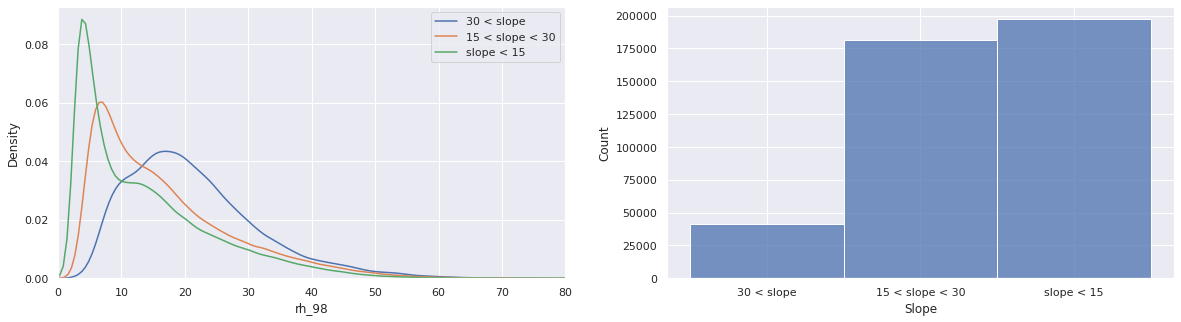

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
df = gedi_burned
df1 = df[df.slope_median > 30]
df2 = df[(df.slope_median > 15) & (df.slope_median < 30)]
df3 = df[df.slope_median < 15]
df1["Slope"] = "30 < slope"
df2["Slope"] = "15 < slope < 30"
df3["Slope"] = "slope < 15"
df = pd.concat([df1, df2, df3])
sns.kdeplot(df[df.slope_median > 30], x="rh_98", ax=ax[0], label="30 < slope")
sns.kdeplot(df[(df.slope_median > 15) & (df.slope_median < 30)], x="rh_98", ax=ax[0], label="15 < slope < 30")
sns.kdeplot(df[df.slope_median < 15], x="rh_98", ax=ax[0], label="slope < 15")
ax[0].legend()
ax[0].set_xlim((0, 80))
sns.histplot(df, x="Slope", ax=ax[1])

# RH 98 recovery

<AxesSubplot: xlabel='time_since_burn', ylabel='NDVI_mean'>

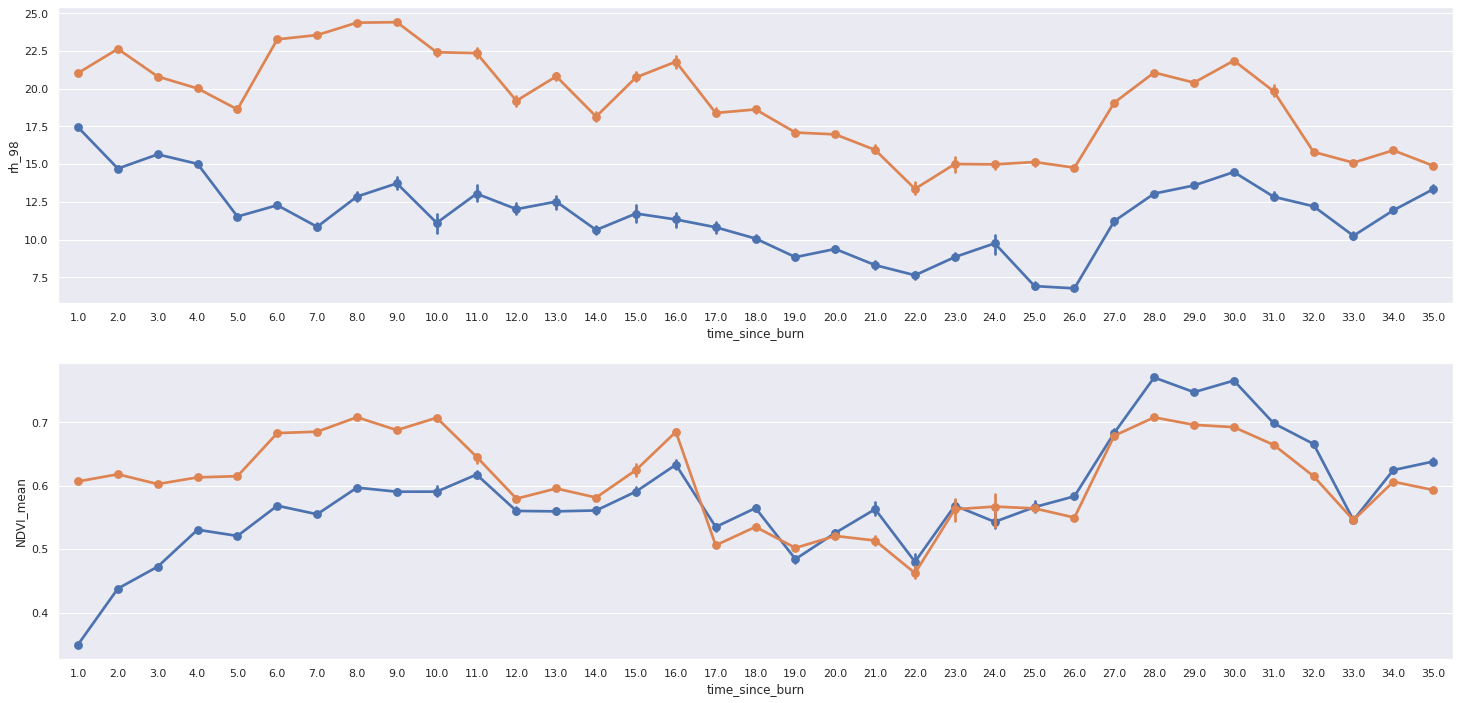

In [61]:
fig, ax = plt.subplots(2, 1, figsize=(25, 12))
df = gedi_burned
sns.pointplot(df, x="time_since_burn", y="rh_98",  ax=ax[0], estimator="median")
sns.pointplot(df, x="time_since_burn", y="rh_98_control",  ax=ax[0], estimator="median")
sns.pointplot(df, x="time_since_burn", y="NDVI_mean",  ax=ax[1], estimator="median")
sns.pointplot(df, x="time_since_burn", y="NDVI_control",  ax=ax[1], estimator="median")

<AxesSubplot: xlabel='time_since_burn', ylabel='NDVI_rel'>

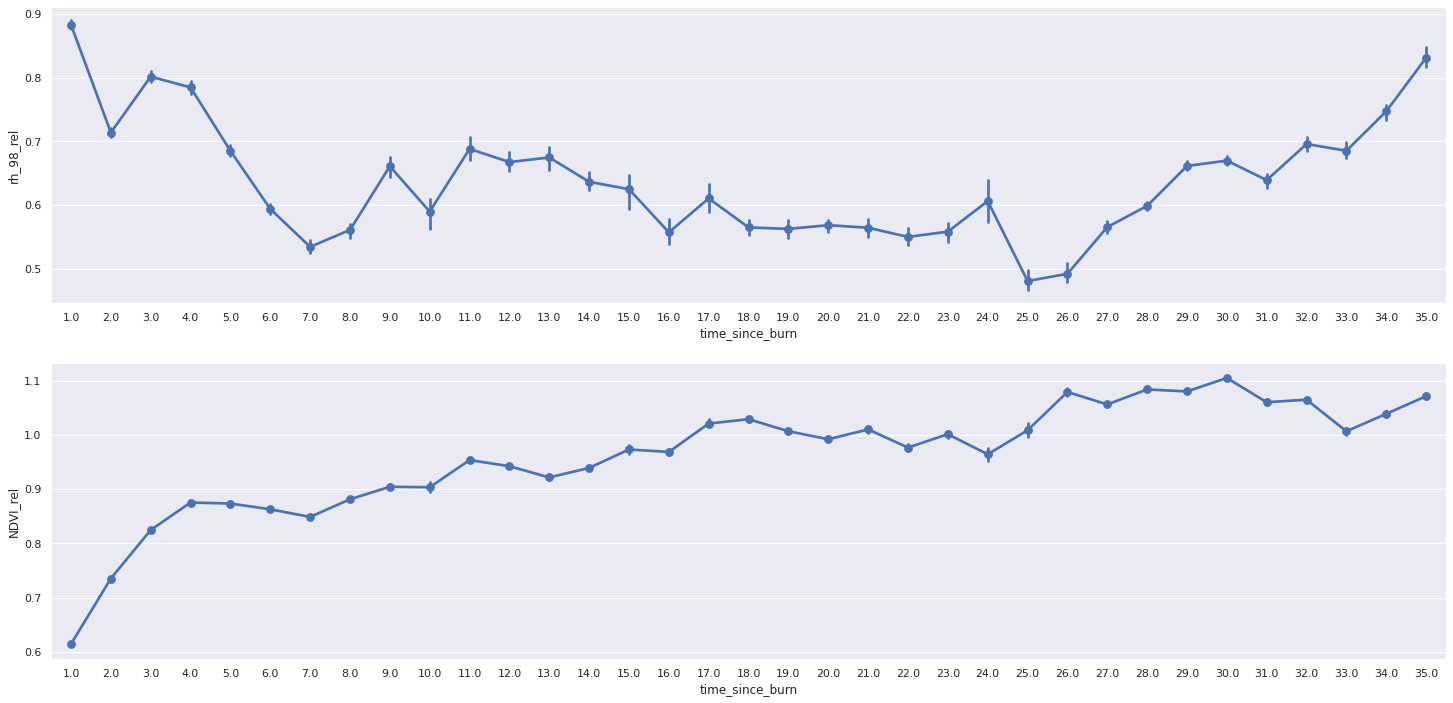

In [63]:
fig, ax = plt.subplots(2, 1, figsize=(25, 12))
df = gedi_burned
sns.pointplot(df, x="time_since_burn", y="rh_98_rel",  ax=ax[0], estimator="median")
sns.pointplot(df, x="time_since_burn", y="NDVI_rel",  ax=ax[1], estimator="median")

## High Severity

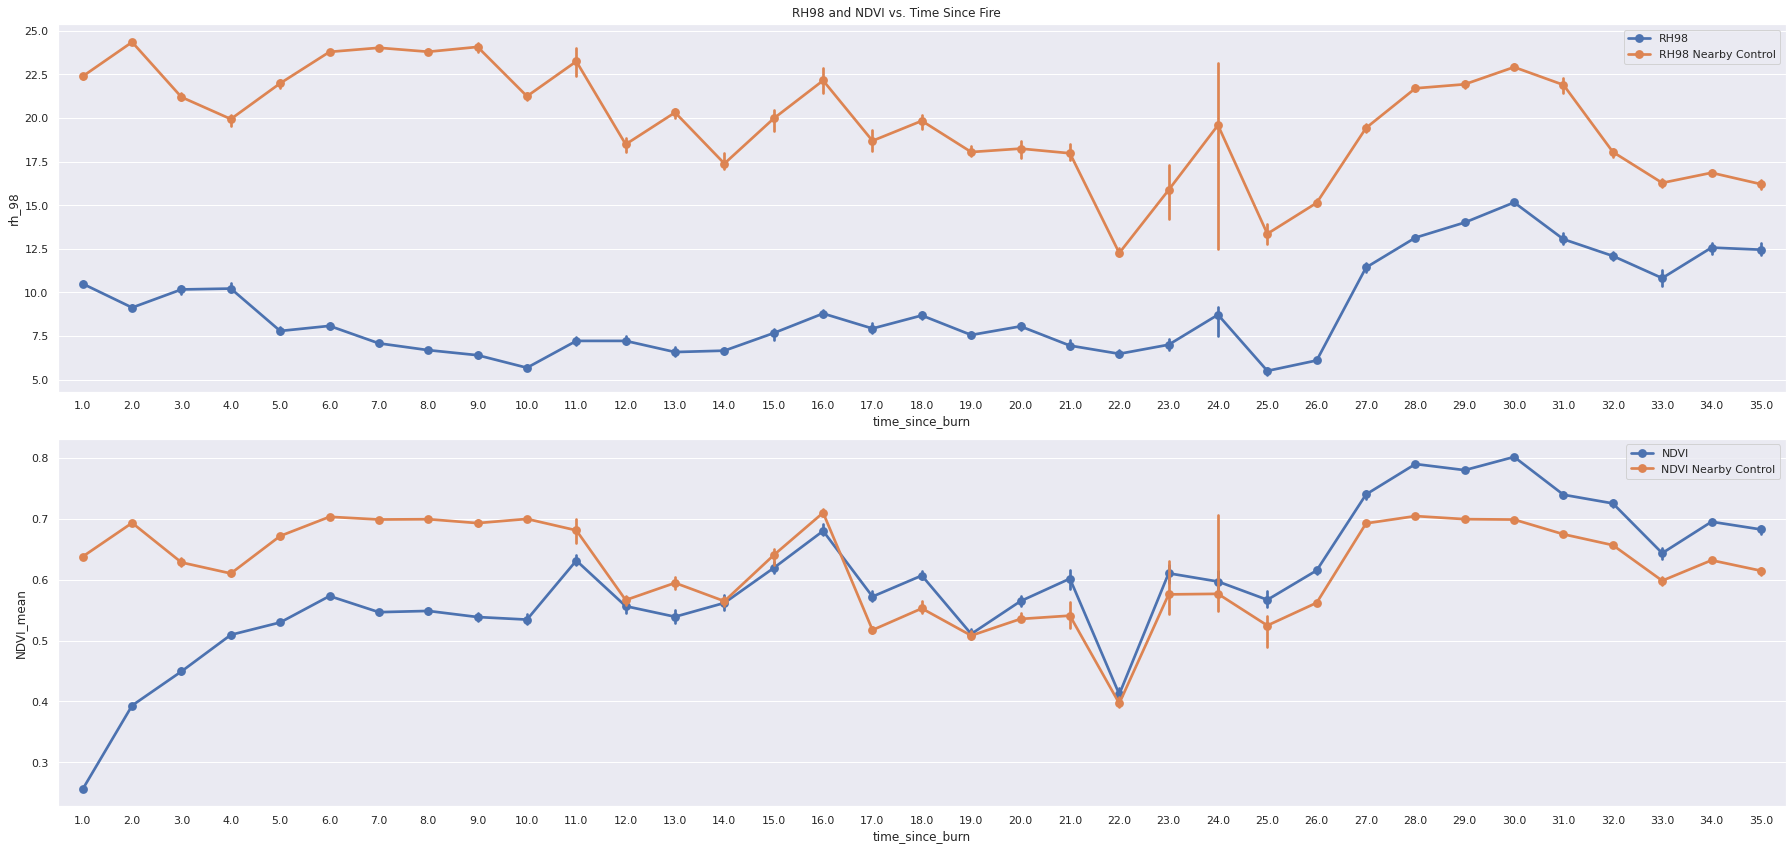

In [65]:
fig, ax = plt.subplots(2, 1, figsize=(25, 12))
df = gedi_burned[gedi_burned.severity == 4]
sns.pointplot(df, x="time_since_burn", y="rh_98",  ax=ax[0], estimator="median", label="RH98")
sns.pointplot(df, x="time_since_burn", y="rh_98_control",  ax=ax[0], estimator="median", label="RH98 Nearby Control")
sns.pointplot(df, x="time_since_burn", y="NDVI_mean",  ax=ax[1], estimator="median", label="NDVI")
sns.pointplot(df, x="time_since_burn", y="NDVI_control",  ax=ax[1], estimator="median", label="NDVI Nearby Control")
ax[0].legend()
ax[1].legend()
fig.suptitle("RH98 and NDVI vs. Time Since Fire")
fig.tight_layout()

In [67]:
df = high_severity
rh_98_rel_medians = df.groupby("time_since_burn").rh_98_rel.median()
slope_medians = df.groupby("time_since_burn").slope_median.median()
elevation_medians = df.groupby("time_since_burn").elevation_median.median()
elevation_difference_tdx_medians = df.groupby("time_since_burn").elevation_difference_tdx.median()

179606


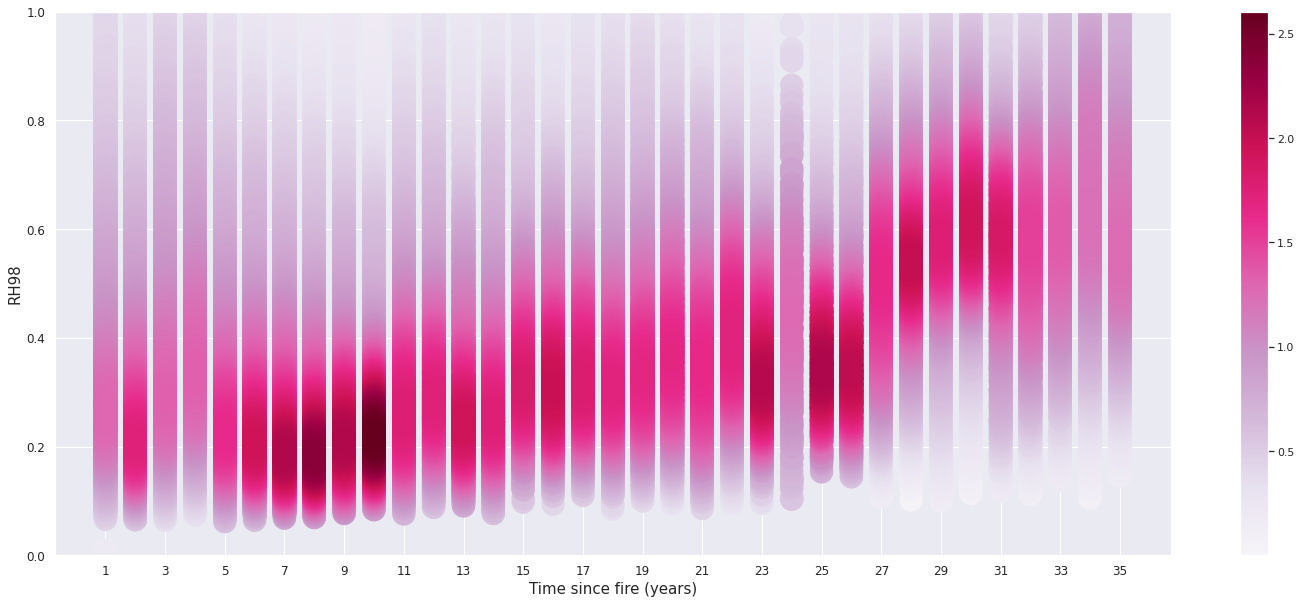

In [87]:
plot_pdf(high_severity,
         'time_since_burn',
         'rh_98_rel',
         "Time since fire (years)",
         "RH98",
         (0, 1))

In [92]:
print(pearsonr(high_severity.rh_98_rel, high_severity.time_since_burn))

PearsonRResult(statistic=0.0658571646193343, pvalue=8.630522495461769e-172)


Text(0, 0.9, 'R^2 = 0.819')

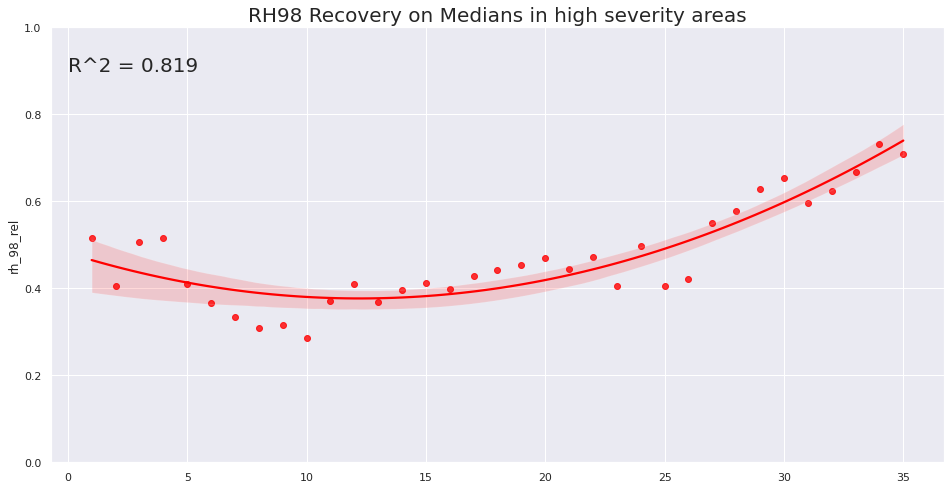

In [85]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.regplot(x=pd.Series(range(1, 36)), y=rh_98_rel_medians, ax=ax, order=2, color="red")
ax.set_title("RH98 Recovery on Medians in high severity areas", fontsize=20)
ax.set_ylim((0, 1))
ax.text(0, 0.9, "R^2 = 0.819", fontsize=20)

In [79]:
import scipy as sp
import statsmodels.api as sm

x = np.array(range(1, 36))
y = rh_98_rel_medians.to_numpy()
X = sm.add_constant(np.stack([x, x**2]).T)
model = sm.OLS(y, X)
fitted_model = model.fit()
print(fitted_model.summary(xname=['const', 'x1', 'x2']))  

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     72.19
Date:                Mon, 30 Oct 2023   Prob (F-statistic):           1.38e-12
Time:                        11:51:56   Log-Likelihood:                 56.059
No. Observations:                  35   AIC:                            -106.1
Df Residuals:                      32   BIC:                            -101.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4814      0.027     17.561      0.0

In [93]:
print(pearsonr(x, y))

PearsonRResult(statistic=0.7129081383856386, pvalue=1.5452746181538776e-06)
